# TP2 - HISTOGRAMAS, KERNELS & MÉTODOS NO SUPERVISADOS USANDO LA EPH

In [71]:
# Importamos las librerías necesarios para responder el TP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parte I
## Traemos la última base lmpia que utilizamos en el TP1

In [72]:
df_copia = pd.read_csv("df_copia.csv", low_memory=False)

In [73]:
print("Dimensiones base:", df_copia.shape)

Dimensiones base: (16665, 249)


In [74]:
# Seleccionamos las variables de interés
variables_interes = [
    "CH04", "CH06", "CH07", "CH08", "NIVEL_ED",
    "ESTADO", "CAT_INAC", "IPCF", "CAT_OCUP", "PP07H",
    "P21", "CH15", "PP10A", "PP04G", "PP3E_TOT", "CH12", "CH13", "CH14",
    "ITF", "PP3F_TOT"
]

# Parte I - Punto 1

In [75]:
# Limpieza de la variable CH06 (edad)

# Reemplazamos edades negativas o mayores a 100 con NaN
df_copia.loc[(df_copia["CH06"] < 0) | (df_copia["CH06"] > 100), "CH06"] = np.nan

# Mostramos las nuevas estadísticas
print("Resumen estadístico de la edad (tras limpieza):")
print(df_copia["CH06"].describe())

Resumen estadístico de la edad (tras limpieza):
count    16488.000000
mean        36.036390
std         22.420587
min          1.000000
25%         17.000000
50%         33.000000
75%         53.000000
max        100.000000
Name: CH06, dtype: float64


Resumen estadístico de la edad:
count    16488.000000
mean        36.036390
std         22.420587
min          1.000000
25%         17.000000
50%         33.000000
75%         53.000000
max        100.000000
Name: CH06, dtype: float64


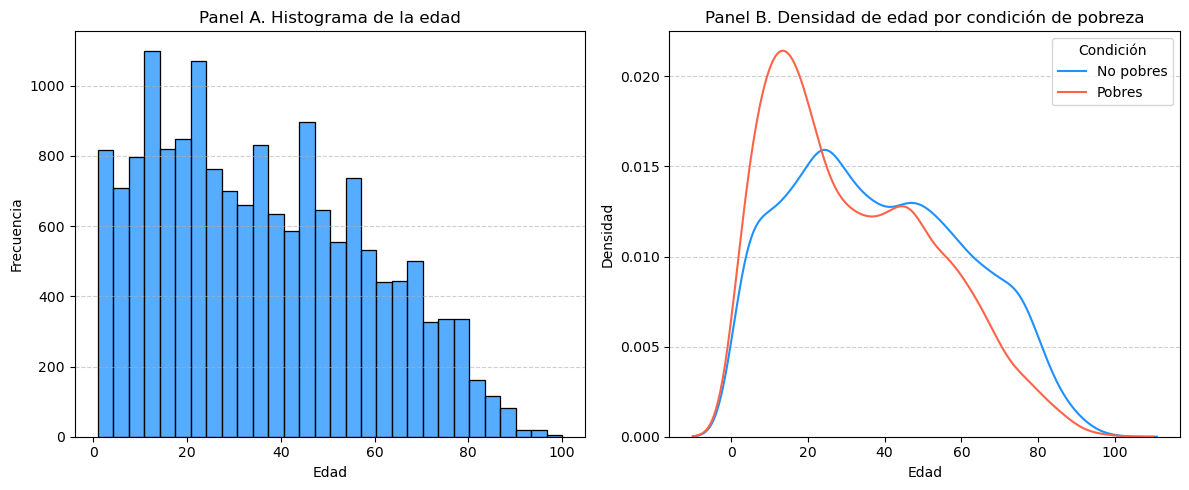

In [76]:
# Creamos la variable edad2
df_copia["edad2"] = df_copia["CH06"] ** 2

# Validamos los valores de edad
print("Resumen estadístico de la edad:")
print(df_copia["CH06"].describe())

# Creamos figura con dos paneles (A y B)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Histograma de edad
sns.histplot(
    data=df_copia,
    x="CH06",
    bins=30,
    kde=False,
    color="#1E90FF",
    ax=axes[0]
)
axes[0].set_title("Panel A. Histograma de la edad")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Frecuencia")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# Panel B: Distribución kernel por pobreza
sns.kdeplot(
    data=df_copia[df_copia["pobre"] == 0],
    x="CH06",
    fill=False,
    color="#1E90FF",
    label="No pobres",
    ax=axes[1]
)
sns.kdeplot(
    data=df_copia[df_copia["pobre"] == 1],
    x="CH06",
    fill=False,
    color="#FF6347",
    label="Pobres",
    ax=axes[1]
)
axes[1].set_title("Panel B. Densidad de edad por condición de pobreza")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Densidad")
axes[1].legend(title="Condición")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Parte I - Punto 2: Variable 'educ'

In [77]:
#Validamos que CH14 este limpia, ya que nos ha generado conflicto
# Mostramos los valores únicos no numéricos en CH14
valores_no_num = df_copia["CH14"][~df_copia["CH14"].astype(str).str.isnumeric()].unique()
print(valores_no_num)

['  ' '3.0' '1.0' nan '4.0' '2.0' '0.0' '99.0' '5.0' '98.0' '6.0' '7.0'
 '9.0' '8.0']


In [78]:
# Convertimos CH14 a numérica de forma segura
df_copia["CH14"] = pd.to_numeric(df_copia["CH14"], errors="coerce")

# Reemplazamos valores especiales (98, 99) o vacíos por NaN
df_copia.loc[df_copia["CH14"].isin([98, 99]) | df_copia["CH14"].isna(), "CH14"] = np.nan

# Verificamos que todo quedó limpio
print(df_copia["CH14"].describe())

count    7965.000000
mean        2.515756
std         1.974259
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: CH14, dtype: float64


In [79]:
# Mostramos los valores únicos no numéricos en CH14
valores_no_num = df_copia["CH14"][~df_copia["CH14"].astype(str).str.isnumeric()].unique()
print(valores_no_num)

[ 2. nan  5.  0.  1.  4.  3.  7.  6.  9.  8.]


In [80]:
# Creamos la variable 'educ' (años de educación formal)

# Iniciamos la variable vacía
df_copia["educ"] = np.nan

# Casos especiales: educación especial, menores de dos años o jardín sin completar se asignan como 0 años
df_copia.loc[df_copia["CH12"] == 9, "educ"] = 0
df_copia.loc[df_copia["CH06"] < 2, "educ"] = 0
df_copia.loc[(df_copia["CH12"] == 1) & (df_copia["CH13"] == 2), "educ"] = 0

# Nivel primario: asignamos años según el último año aprobado (CH14) si no completó el nivel
cond_prim = (df_copia["CH12"] == 2) & (df_copia["CH13"] == 2)
for i in range(0, 7):
    df_copia.loc[cond_prim & (df_copia["CH14"] == i), "educ"] = 1 + i

# Nivel EGB: tiene hasta 9 años posibles
cond_egb = (df_copia["CH12"] == 3) & (df_copia["CH13"] == 2)
for i in range(0, 9):
    df_copia.loc[cond_egb & (df_copia["CH14"] == i), "educ"] = 1 + i

# Nivel secundario: dura 6 años aproximadamente, se suma a la base acumulada de educación obligatoria
cond_sec = (df_copia["CH12"] == 4) & (df_copia["CH13"] == 2)
for i, val in enumerate([0, 1, 2, 3, 4, 5]):
    df_copia.loc[cond_sec & (df_copia["CH14"] == val), "educ"] = 8 + i

# Nivel polimodal: se asume menor duración (4 años)
cond_poli = (df_copia["CH12"] == 5) & (df_copia["CH13"] == 2)
for i, val in enumerate([0, 1, 2, 3]):
    df_copia.loc[cond_poli & (df_copia["CH14"] == val), "educ"] = 10 + i

# Nivel terciario: se asume una duración promedio de 3 años
cond_terc = (df_copia["CH12"] == 6) & (df_copia["CH13"] == 2)
df_copia.loc[cond_terc & (df_copia["CH14"] == 0), "educ"] = 13
df_copia.loc[cond_terc & (df_copia["CH14"] == 1), "educ"] = 14
df_copia.loc[cond_terc & (df_copia["CH14"].between(2, 97)), "educ"] = 15

# Nivel universitario: se asume una duración promedio de hasta 6 años
cond_univ = (df_copia["CH12"] == 7) & (df_copia["CH13"] == 2)
df_copia.loc[cond_univ & (df_copia["CH14"] == 0), "educ"] = 13
df_copia.loc[cond_univ & (df_copia["CH14"] == 1), "educ"] = 14
df_copia.loc[cond_univ & (df_copia["CH14"] == 2), "educ"] = 15
df_copia.loc[cond_univ & (df_copia["CH14"] == 3), "educ"] = 16
df_copia.loc[cond_univ & (df_copia["CH14"] == 4), "educ"] = 17
df_copia.loc[cond_univ & (df_copia["CH14"].between(5, 97)), "educ"] = 18

# Nivel posgrado: se asume una duración de hasta 4 años adicionales
cond_posg = (df_copia["CH12"] == 8) & (df_copia["CH13"] == 2)
df_copia.loc[cond_posg & (df_copia["CH14"] == 0), "educ"] = 19
df_copia.loc[cond_posg & (df_copia["CH14"] == 1), "educ"] = 20
df_copia.loc[cond_posg & (df_copia["CH14"] == 2), "educ"] = 21
df_copia.loc[cond_posg & (df_copia["CH14"].between(3, 97)), "educ"] = 22

# Casos que completaron el nivel: asignamos los años totales acumulados según el nivel finalizado
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 1), "educ"] = 1
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 2), "educ"] = 8
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 3), "educ"] = 11
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"].isin([4, 5])), "educ"] = 13
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 6), "educ"] = 16
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 7), "educ"] = 19
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 8), "educ"] = 23

# Ajustes finales: eliminamos valores imposibles o fuera de rango
df_copia.loc[df_copia["educ"] < 0, "educ"] = np.nan
df_copia.loc[df_copia["educ"] > 23, "educ"] = 23

# Resumen descriptivo de la variable resultante
print("Resumen estadístico de la variable 'educ':")
print(df_copia["educ"].describe(percentiles=[0.5]).round(2))

Resumen estadístico de la variable 'educ':
count    15828.00
mean        10.48
std          5.01
min          0.00
50%         11.00
max         23.00
Name: educ, dtype: float64


# Parte I - Punto 3: Ajuste del ITF

In [81]:

# Copiamos la base
df_ingresos = df_copia.copy()

# --------------------------------------------------------------------
# Definimos los valores de la Canasta Básica Total (CBT)
# Estos valores provienen del TP1 y de la documentación de la EPH:
# - En el primer trimestre de 2005 la CBT para un adulto equivalente fue $205.07.
# - En el primer trimestre de 2025 la CBT fue $365,177.
# Usamos estas cifras para ajustar los ingresos de 2005 a precios de 2025.
# --------------------------------------------------------------------
CBT_2005 = 205.07
CBT_2025 = 365177

# Calculamos el factor de ajuste (cuántas veces aumentó el costo de la CBT)
factor_ajuste = CBT_2025 / CBT_2005

# Mostramos el resultado en pantalla para documentar el ajuste
print("==========================================")
print("Factor de ajuste de precios 2005 → 2025")
print(f"CBT 2005: ${CBT_2005:,.2f}")
print(f"CBT 2025: ${CBT_2025:,.0f}")
print(f"Factor de ajuste: {factor_ajuste:,.1f} veces")
print("==========================================\n")

# Ajustamos los ingresos de 2005 a valores de 2025 usando el factor de precios
df_ingresos["ITF_ajustado"] = np.where(
    df_ingresos["AÑO"] == 2005,
    df_ingresos["ITF"] * factor_ajuste,
    df_ingresos["ITF"]
)


Factor de ajuste de precios 2005 → 2025
CBT 2005: $205.07
CBT 2025: $365,177
Factor de ajuste: 1,780.7 veces



Resumen estadístico del ingreso total familiar (ajustado a 2025):
count       16665.00
mean      2004995.40
std       2816852.15
min             0.00
25%        534222.95
50%       1380000.00
75%       2671114.74
max      92687681.52
Name: ingreso_total_familiar, dtype: float64
Línea de pobreza (ingreso necesario promedio en 2025): $1,055,110



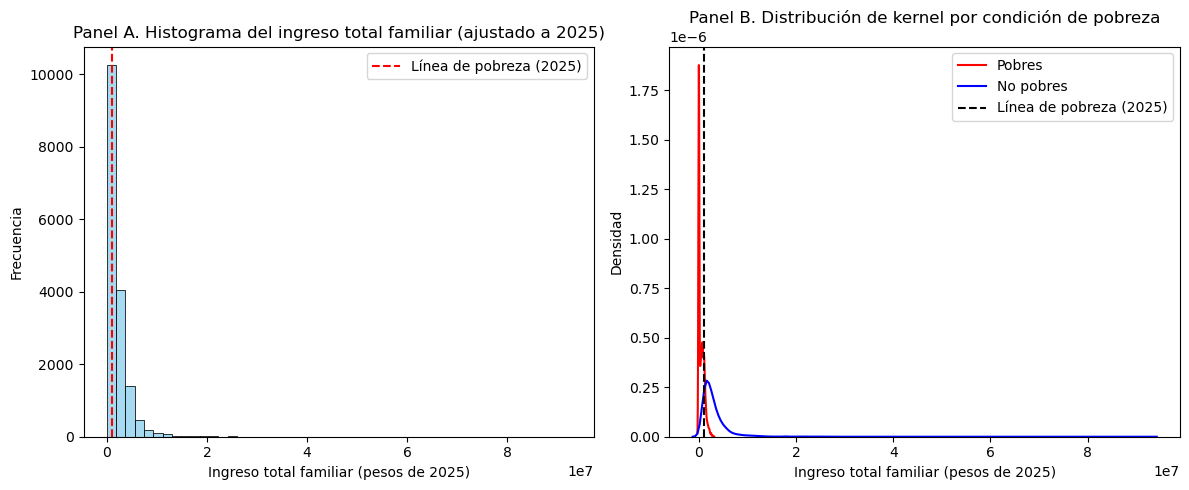

In [82]:
# Creamos una nueva variable con el ingreso total familiar en pesos de 2025
df_ingresos["ingreso_total_familiar"] = df_ingresos["ITF_ajustado"]

# Resumen estadístico general
print("Resumen estadístico del ingreso total familiar (ajustado a 2025):")
print(df_ingresos["ingreso_total_familiar"].describe().round(2))

# Línea de pobreza: usamos la variable 'ingreso_necesario' del TP1,
# que representa el ingreso mínimo requerido por hogar para no ser pobre.
# Calculamos su promedio para graficar como línea de referencia.

linea_pobreza_2025 = df_ingresos.loc[df_ingresos["AÑO"] == 2025, "ingreso_necesario"].mean()
print(f"Línea de pobreza (ingreso necesario promedio en 2025): ${linea_pobreza_2025:,.0f}\n")

# Panel A: Histograma general del ingreso familiar (ajustado a precios de 2025)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(
    df_ingresos["ingreso_total_familiar"],
    bins=50,
    color="skyblue",
    kde=False
)
plt.axvline(linea_pobreza_2025, color="red", linestyle="--", label="Línea de pobreza (2025)")
plt.title("Panel A. Histograma del ingreso total familiar (ajustado a 2025)")
plt.xlabel("Ingreso total familiar (pesos de 2025)")
plt.ylabel("Frecuencia")
plt.legend()


# Panel B: Distribución de kernel por condición de pobreza
# Mostramos las curvas de densidad para pobres y no pobres

plt.subplot(1, 2, 2)
sns.kdeplot(
    data=df_ingresos[df_ingresos["pobre"] == 1],
    x="ingreso_total_familiar",
    color="red",
    label="Pobres"
)
sns.kdeplot(
    data=df_ingresos[df_ingresos["pobre"] == 0],
    x="ingreso_total_familiar",
    color="blue",
    label="No pobres"
)
plt.axvline(linea_pobreza_2025, color="black", linestyle="--", label="Línea de pobreza (2025)")
plt.title("Panel B. Distribución de kernel por condición de pobreza")
plt.xlabel("Ingreso total familiar (pesos de 2025)")
plt.ylabel("Densidad")
plt.legend()

plt.tight_layout()
plt.show()

# Parte 1 - Punto 4: Creación de la variable horastrab y análisis descriptivo

In [83]:
# Creamos la variable horastrab sumando las horas en la ocupación principal y secundaria
df_copia["horastrab"] = df_copia["PP3E_TOT"].fillna(0) + df_copia["PP3F_TOT"].fillna(0)

# Filtramos solo a los jefes de hogar
# Según la EPH, la variable CH07 identifica el parentesco con el jefe del hogar
# En general, CH07 == 1 corresponde al jefe/a del hogar
df_jefes = df_copia[df_copia["CH07"] == 1].copy()

# Calculamos las estadísticas descriptivas
desc_horas = df_jefes["horastrab"].describe(percentiles=[0.5]).round(2)
print("Estadísticas descriptivas de horas trabajadas (jefes de hogar):")
print(desc_horas)

Estadísticas descriptivas de horas trabajadas (jefes de hogar):
count    2400.00
mean       33.35
std        83.06
min         0.00
50%        29.50
max      1047.00
Name: horastrab, dtype: float64


# Parte 1 - Punto 5: Resumen de la base final para Gran Buenos Aires

In [84]:
# Cantidad total de observaciones por año
obs_por_anio = df_copia["AÑO"].value_counts().sort_index()

# Observaciones con valores faltantes en la variable pobre
nas_por_anio = df_copia.groupby("AÑO")["pobre"].apply(lambda x: x.isna().sum())

# Cantidad de pobres y no pobres
pobres_por_anio = df_copia.groupby("AÑO")["pobre"].sum()
no_pobres_por_anio = df_copia.groupby("AÑO")["pobre"].apply(lambda x: (x == 0).sum())

# Cantidad de variables limpias y homogeneizadas
# Suponemos que corresponde al total de columnas sin valores faltantes en cada año
vars_limpias = df_copia.groupby("AÑO").apply(
    lambda x: x.dropna(axis=1, how="any").shape[1]
)

# Creamos el DataFrame resumen
tabla_resumen = pd.DataFrame({
    "Cantidad observaciones": obs_por_anio,
    "Observaciones con NAs en 'pobre'": nas_por_anio,
    "Cantidad de Pobres": pobres_por_anio,
    "Cantidad de No Pobres": no_pobres_por_anio,
    "Variables limpias y homogeneizadas": vars_limpias
}).reset_index().rename(columns={"AÑO": "Año"})

# Agregamos el total general
totales = pd.DataFrame({
    "Año": ["Total"],
    "Cantidad observaciones": [df_copia.shape[0]],
    "Observaciones con NAs en 'pobre'": [df_copia["pobre"].isna().sum()],
    "Cantidad de Pobres": [df_copia["pobre"].sum()],
    "Cantidad de No Pobres": [(df_copia["pobre"] == 0).sum()],
    "Variables limpias y homogeneizadas": [df_copia.dropna(axis=1, how="any").shape[1]]
})

# Unimos los resultados
tabla_resumen = pd.concat([tabla_resumen, totales], ignore_index=True)

# Mostramos la tabla
print("Tabla 1. Resumen de la base final para Gran Buenos Aires")
print(tabla_resumen.to_string(index=False))


Tabla 1. Resumen de la base final para Gran Buenos Aires
  Año  Cantidad observaciones  Observaciones con NAs en 'pobre'  Cantidad de Pobres  Cantidad de No Pobres  Variables limpias y homogeneizadas
 2005                    9484                                 0                2506                   6978                                 173
 2025                    7181                                 0                4204                   2977                                  90
Total                   16665                                 0                6710                   9955                                  67


C:\Users\manue\AppData\Local\Temp\ipykernel_29260\2284664935.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vars_limpias = df_copia.groupby("AÑO").apply(
